In [14]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
from scipy.signal import argrelextrema
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import pickle
import datetime
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt
from scipy.stats import binned_statistic
import scipy.stats

In [5]:
aug31 = pickle.load(open('31aug_wfms.p','rb'))
sep23 = pickle.load(open('23sep_wfms.p','rb'))
sep10 = pickle.load(open('10sep_wfms.p','rb'))
sep15 = pickle.load(open('15sep_wfms.p','rb'))
sep20 = pickle.load(open('20sep_wfms.p','rb'))
nearfardict = pickle.load(open('nearfar.p','rb'))

In [29]:
freq = 'ku'

thresh = 0.05

info = {'aug31':{'data':aug31},
        'sep10':{'data':sep10},
        'sep15':{'data':sep15},
        'sep20':{'data':sep20},
        'sep23':{'data':sep23}}
    

In [30]:
tightnear  = kt.get_range_index(1.55,nearfardict[freq]['range'])
tightfar = kt.get_range_index(1.65,nearfardict[freq]['range'])

In [31]:
for key in info.keys():
    info[key]['npeaks']=[]
    info[key]['double_peak_indices']={}
    info[key]['single_peak_indices']={}


for key in info.keys():
    
    df = info[key]['data']['ku']
    
    skews = []
    
    for i in range(df.shape[0]):

        power = df['vv'].iloc[i][tightnear:tightfar]
        
        skews.append(scipy.stats.skew(power))

        # Identify all peaks more than 10% of max power

        ### Identify the indexes of all local maxima

        max_inds = argrelextrema(power, np.greater)[0]

        ### Catalogue the characteristics of the local maxima

        list_of_dicts_for_df = [{'ind':q,'power':power[q],
                                 'range':nearfardict[freq]['range'][tightnear:tightfar][q]} for q in max_inds]

        ### Sort dataframe so most powerful peaks at top

        peaks_df = pd.DataFrame(list_of_dicts_for_df).sort_values('power',ascending=False)

        max_power = peaks_df.iloc[0]['power']

        # Calculate power of each peak relative to max power
        peaks_df['rel_power'] = [x/max_power for x in peaks_df['power']]

        # Filter out weak peaks with a threshold to remove sidelobes
        peaks_df = peaks_df[peaks_df['rel_power']>thresh]

        # Sort peaks into ascending range
        peaks_df = peaks_df.sort_values('range',ascending=True)

        # Log npeaks to main dataframe
        info[key]['npeaks'].append(peaks_df.shape[0])

        # Investigate double-peaks
        if peaks_df.shape[0] == 2:

            info[key]['double_peak_indices'][i] = peaks_df
            
        # Investigate single-peaks
        if peaks_df.shape[0] == 1:

            info[key]['single_peak_indices'][i] = peaks_df

    df['npeaks']=info[key]['npeaks']
    
    df['skew']=skews

In [35]:
df.head()

,index,vv,hv,vh,hh,corr,along_track,speed,xtilt,atilt,npeaks,skew
0,69,"[1.4326659515554156e-07, 1.399010237266009e-07...",0.001166,0.000904,0.031384,0.858640,2.241374,0.631624,0.055080,0.959486,1,0.391991
1,68,"[1.4588843522350183e-06, 1.672868006720674e-06...",0.002228,0.000566,1.148095,0.728495,2.241374,0.000000,-0.033048,1.201836,1,0.422552
2,67,"[1.0369423302529262e-06, 1.127845392440285e-06...",0.000821,0.000326,0.648359,0.995763,2.258073,0.634629,-0.033048,1.201836,1,0.319446
3,66,"[1.3149901931164226e-06, 1.4218171368560242e-0...",0.001724,0.001588,0.811898,0.996844,2.258073,0.000000,-0.264382,0.441738,1,0.416346
4,71,"[3.999046873737481e-07, 5.633633886691148e-07,...",0.001211,0.000942,0.863487,0.965812,2.424613,0.630418,0.330477,0.540881,1,-0.015304


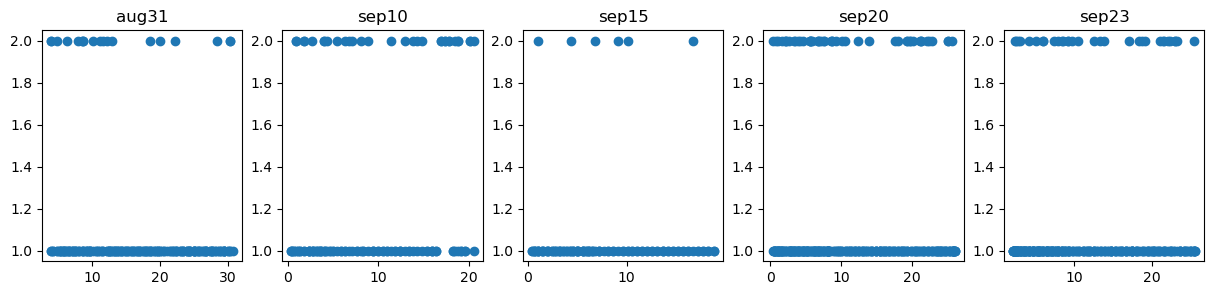

In [38]:
fig, axs =plt.subplots(1,5,figsize=(15,3))

for key,ax in zip(info.keys(),axs.reshape(-1)):
       
    df = info[key]['data']['ku']
    
    ax.scatter(df['along_track'],df['npeaks'])
    
    # ax.hist(df['npeaks'])
    ax.set_title(key)
plt.show()

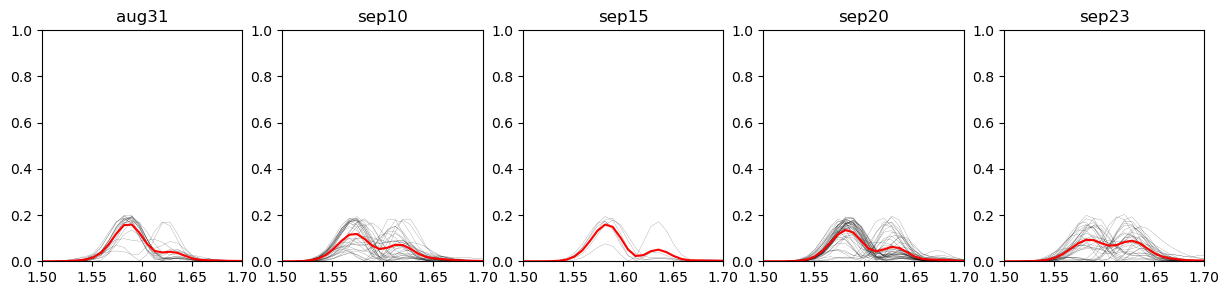

In [47]:
fig, axs =plt.subplots(1,5,figsize=(15,3))

for key,ax in zip(info.keys(),axs.reshape(-1)):
    
    df = info[key]['data']['ku']
    
    powers = []
    for i in range(df.shape[0]):

        power = df['vv'].iloc[i]
        
        
        if df['npeaks'].iloc[i]==2:
            powers.append(power/np.sum(power))
            ax.plot(nearfardict[freq]['range'],power/np.sum(power),color='k',lw=0.1)
    
    ave = np.nanmean(powers,axis=0)
    
    info[key]['average']=ave
    
    ax.plot(nearfardict[freq]['range'],ave,color='r')
        
    ax.set_xlim(1.5,1.7)
    ax.set_ylim(0,1)
    ax.set_title(key)

plt.show()

In [ ]:
for key in info.keys():
    ave = info[key]['average']
    
    print(key,scipy.stats.skew(ave))

In [18]:
mean_skews = []

for key in info.keys():
    
    df = info[key]['data']['ku']
    
    mean_skews.append(np.nanmean(df['skew']))
    
print(mean_skews)

[0.48886074462006296, 0.3496459292070498, 0.4228303186872748, 0.40975740027643814, 0.3417557595062936]


In [97]:
for key in info.keys():

    peak_separations = []
    peak_ratios = []
    p2_power = []
    p1_power = []

    ranges=nearfardict[freq]['range']
    
    df = info[key]['data']['ku']

    for i,peaks_df in info[key]['double_peak_indices'].items():

        power = df['vv'].iloc[i]

        peak_separations.append( np.diff(peaks_df['range'])[0] )

        peak_ratios.append(peaks_df.iloc[0]['power']/peaks_df.iloc[1]['power'])

        p2_power.append(peaks_df.iloc[1]['power'])
        p1_power.append(peaks_df.iloc[0]['power'])

    peak_ratios = np.array(peak_ratios)
    
    info[key]['peak_ratios']=peak_ratios
    info[key]['p1_power']=p1_power
    info[key]['p2_power']=p2_power
    info[key]['peak_separations']=peak_separations

In [98]:
mean_p2s=[]

for key in info.keys():
    mean_p2 = np.nanmean(info[key]["p2_power"])
    std_p2 = np.nanstd(info[key]["p2_power"])
    mean_p2s.append(mean_p2)
    print(f'{key} p2 power: {mean_p2} +/- {std_p2}')
    print()

aug31 p2 power: 0.003992048766705183 +/- 0.0032219109789878957

sep10 p2 power: 0.0029182522627525906 +/- 0.001739774729330627

sep15 p2 power: 0.0019047647350329284 +/- 0.0011375194798946564

sep20 p2 power: 0.002042886545439581 +/- 0.0014180920397499246

sep23 p2 power: 0.0013800680902222506 +/- 0.0011700235481030164



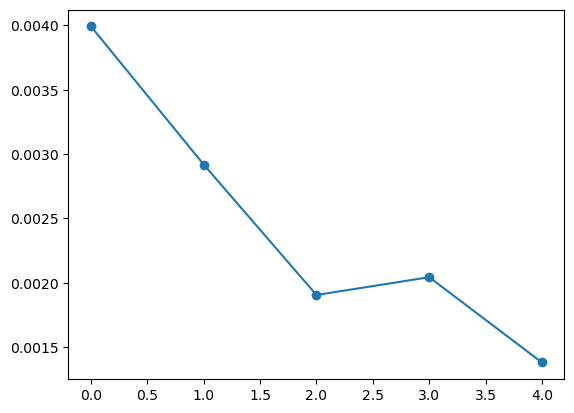

In [103]:
plt.plot(mean_p2s,marker='o')

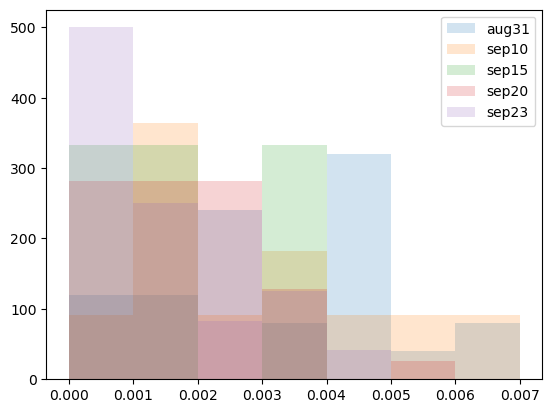

In [99]:
for key in info.keys():
    
    plt.hist(info[key]['p2_power'],
             label=key,
             alpha=0.2,
             density=True,
             bins=np.arange(0,0.008,0.001))
    
plt.legend()

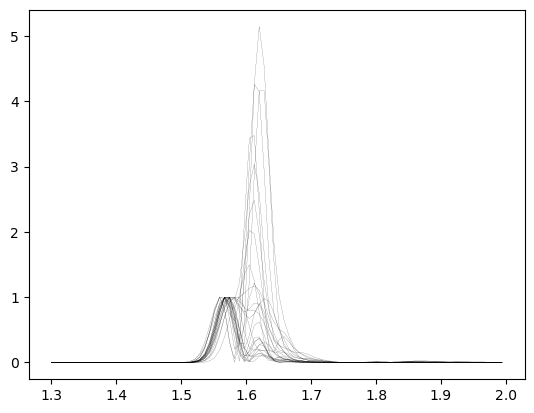

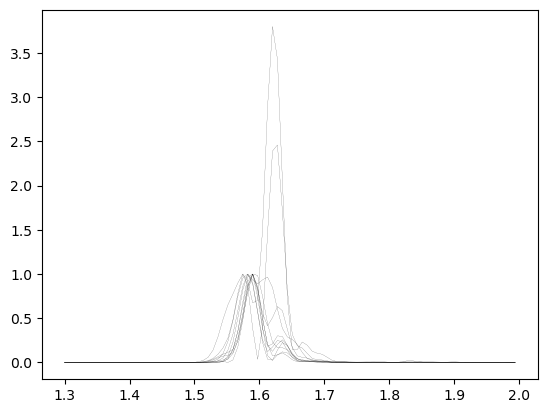

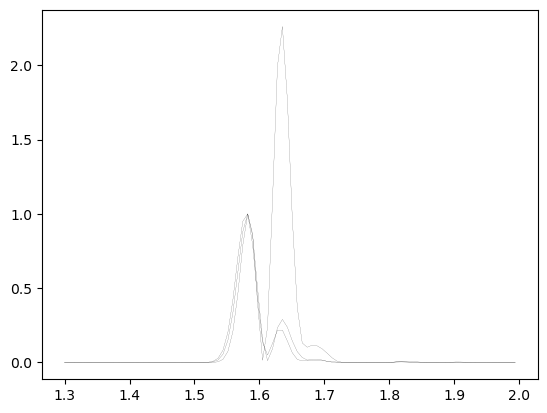

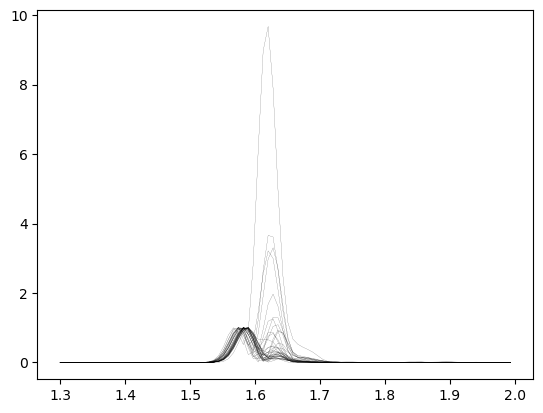

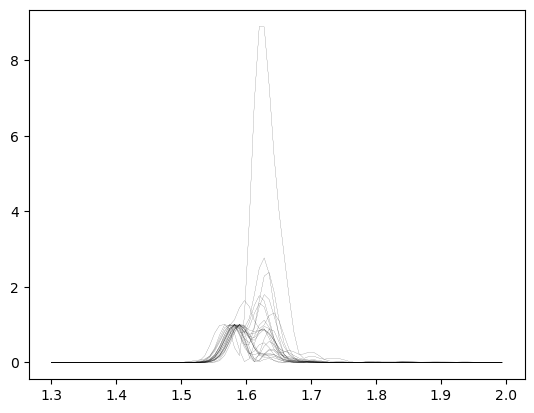

In [100]:
for key in info.keys():

    ranges=nearfardict[freq]['range']
    
    df = info[key]['data']['ku']

    for i,peaks_df in info[key]['double_peak_indices'].items():

        power = df['vv'].iloc[i]

        # plt.plot(ranges-peaks_df.iloc[0]['range'],power/peaks_df.iloc[0]['power'],color='k',lw=0.1)
        
        plt.plot(ranges,power/peaks_df.iloc[1]['power'],color='k',lw=0.1)

    plt.show()

In [101]:
for key in info.keys():

    p_power = []
    p_range = []

    ranges=nearfardict[freq]['range']
    
    df = info[key]['data']['ku']

    for i,peaks_df in info[key]['single_peak_indices'].items():

        power = df['vv'].iloc[i]

        p_power.append(peaks_df.iloc[0]['power'])
        p_range.append(peaks_df.iloc[0]['range'])

    info[key]['p_power']=p_power
    info[key]['p_range']=p_range

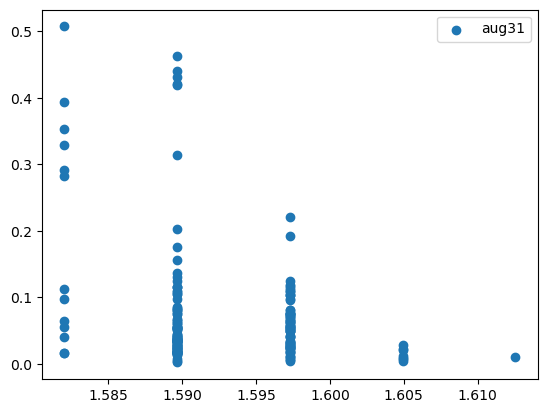

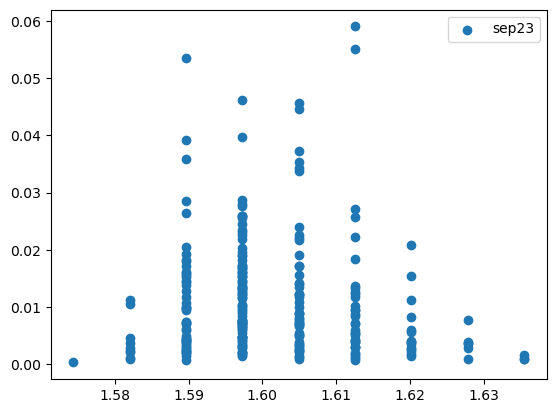

In [52]:
for key in list(info.keys())[:2]:
    
    plt.scatter(info[key]['p_range'],info[key]['p_power'],label=key)
    
    plt.legend()
    
    plt.show()